# Mine domain 3. Extract subgroups with high concentration of PHAs

In [1]:
import pickle
from  copy import deepcopy
import numpy as np
import pandas as pd
from sklearn import neighbors, svm
import matplotlib as mpl

# Import Asterion modules
import read_database as rdb
import learn_data as ld
import asterion_learn as al
import visualize_data as vd

# Matplotlib settings for the current notebook
%matplotlib inline
# font = {'size': 25}
font = {'size': 16}
mpl.rc('font', **font)

** Load NEAs from the 3-rd domain **

In [2]:
dirpath = './asteroid_data/'
real_datasets = ['haz_real', 'nohaz_real']
gen_datasets = ['haz_gen', 'nohaz_gen']
genu_datasets = ['haz_gen', 'nohaz_gen']
name_sufixes = ['_dom3.p', '_dom3_rest.p']

In [3]:
dumps_real = [dirpath + ds + ns for ns in name_sufixes for ds in real_datasets]
dumps_gen = [dirpath + ds + ns for ns in name_sufixes for ds in gen_datasets]
dumps_genu = [dirpath + ds + ns for ns in name_sufixes for ds in genu_datasets]

haz_real, nohaz_real, haz_real_rest, nohaz_real_rest = map(rdb.loadObject, dumps_real)
haz_gen, nohaz_gen, haz_gen_rest, nohaz_gen_rest = map(rdb.loadObject, dumps_gen)
haz_genu, nohaz_genu, haz_genu_rest, nohaz_genu_rest = map(rdb.loadObject, dumps_genu)

In [4]:
gen_num = sum(map(len, [haz_gen, nohaz_gen]))
real_num = sum(map(len, [haz_real, nohaz_real]))

print "Number of virtual asteroids in the domain:", gen_num
print "Number of real asteroids in the domain:", real_num

Number of virtual asteroids in the domain: 5210
Number of real asteroids in the domain: 86


** Investigate distributions of NEAs orbital parameters in the 3-rd domain **

In [5]:
# vd.plot_alldistcombs(haz_gen, nohaz_gen, labels=True)

---
## Atiras & Atens

In [6]:
haz_gen_extracted_aa = []
nohaz_gen_trapped_aa = []

haz_real_extracted_aa = []
nohaz_real_trapped_aa = []

** Atiras **

In [7]:
haz_gen_atiras, haz_gen_atiras_num = rdb.get_atiras(haz_gen)
nohaz_gen_atiras, nohaz_gen_atiras_num = rdb.get_atiras(nohaz_gen)
atiras_gen_num = haz_gen_atiras_num + nohaz_gen_atiras_num

haz_real_atiras, haz_real_atiras_num = rdb.get_atiras(haz_real)
nohaz_real_atiras, nohaz_real_atiras_num = rdb.get_atiras(nohaz_real)
atiras_real_num = haz_real_atiras_num + nohaz_real_atiras_num

print "Number of virtual Atiras:", atiras_gen_num
print "Number of real Atiras:", atiras_real_num

Number of virtual Atiras: 17
Number of real Atiras: 1


** Atens **

In [8]:
haz_gen_atens, haz_gen_atens_num = rdb.get_atens(haz_gen)
nohaz_gen_atens, nohaz_gen_atens_num = rdb.get_atens(nohaz_gen)
atens_gen_num = haz_gen_atens_num + nohaz_gen_atens_num

haz_real_atens, haz_real_atens_num = rdb.get_atens(haz_real)
nohaz_real_atens, nohaz_real_atens_num = rdb.get_atens(nohaz_real)
atens_real_num = haz_real_atens_num + nohaz_real_atens_num

print "Number of virtual Atens:", atens_gen_num
print "Number of real Atens:", atens_real_num

Number of virtual Atens: 546
Number of real Atens: 18


** Atiras + Atens **

In [9]:
haz_gen_atiras_atens = pd.concat((haz_gen_atiras, haz_gen_atens))
nohaz_gen_atiras_atens = pd.concat((nohaz_gen_atiras, nohaz_gen_atens))

haz_gen_atiras_atens_num = len(haz_gen_atiras_atens)
nohaz_gen_atiras_atens_num = len(nohaz_gen_atiras_atens)
atiras_atens_gen_num = haz_gen_atiras_atens_num + nohaz_gen_atiras_atens_num

haz_real_atiras_atens = pd.concat((haz_real_atiras, haz_real_atens))
nohaz_real_atiras_atens = pd.concat((nohaz_real_atiras, nohaz_real_atens))

haz_real_atiras_atens_num = len(haz_real_atiras_atens)
nohaz_real_atiras_atens_num = len(nohaz_real_atiras_atens)
atiras_atens_real_num = haz_real_atiras_atens_num + nohaz_real_atiras_atens_num

In [10]:
print "Number of virtual PHAs in the group:", haz_gen_atiras_atens_num
print "Number of virtual NHAs in the group:", nohaz_gen_atiras_atens_num
print "Number of virtual Atiras and Atens:", atiras_atens_gen_num
print "Virtual Atiras and Atens group weight:", float(atiras_atens_gen_num)/gen_num

Number of virtual PHAs in the group: 148
Number of virtual NHAs in the group: 415
Number of virtual Atiras and Atens: 563
Virtual Atiras and Atens group weight: 0.108061420345


In [11]:
print "Number of real PHAs in the group:", haz_real_atiras_atens_num
print "Number of real NHAs in the group:", nohaz_real_atiras_atens_num
print "Number of real Atiras and Atens:", atiras_atens_real_num
print "Real Atiras and Atens group weight:", float(atiras_atens_real_num)/real_num

Number of real PHAs in the group: 1
Number of real NHAs in the group: 18
Number of real Atiras and Atens: 19
Real Atiras and Atens group weight: 0.220930232558


In [12]:
# vd.display_allparams([haz_gen_atiras_atens, nohaz_gen_atiras_atens], vd.combs, vd.colnames)

### Split Atiras and Atens by a *w*-*i* surface

** Amplify datasets by their symetric copies over the 'w' parameter **

In [13]:
haz_gen_atiras_atens_se = ld.add_doublemirror_column(haz_gen_atiras_atens, 'w', 180.0)
nohaz_gen_atiras_atens_se = ld.add_doublemirror_column(nohaz_gen_atiras_atens, 'w', 180.0)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


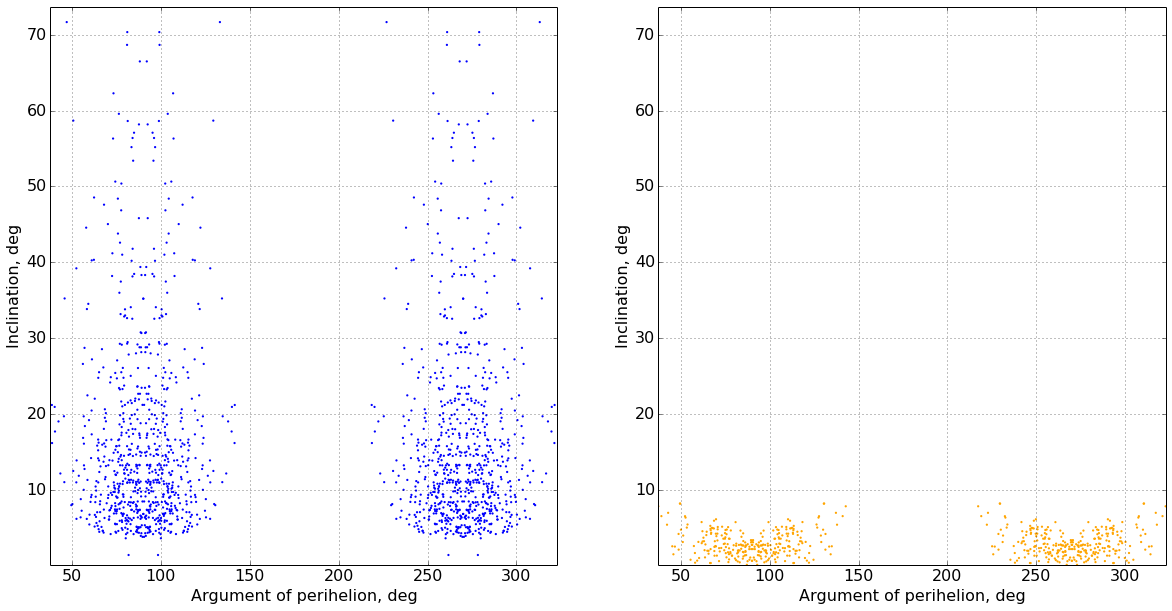

In [14]:
cutcol = ['w', 'i']
vd.plot_distributions2d(cutcol, haz_gen_atiras_atens_se, nohaz_gen_atiras_atens_se, labels=True)

** Cut *w* and *i* columns and nomalize datasets**

In [15]:
cutcol = ['w', 'i']
pairs, atiras_atens_wi_sc = ld.cut_normalize(cutcol, [haz_gen_atiras_atens, nohaz_gen_atiras_atens], 
                                                      [haz_real_atiras_atens, nohaz_real_atiras_atens],
                                                      [haz_gen_atiras_atens_se, nohaz_gen_atiras_atens_se])
haz_gen_cut, nohaz_gen_cut = pairs[0]
haz_real_cut, nohaz_real_cut = pairs[1]
haz_gen_se_cut, nohaz_gen_se_cut = pairs[2]

** Find decision surface with SVM **

In [16]:
clf_aa = svm.SVC(gamma=80.0, C=0.4, class_weight={0: 1.1})
xtrain, ytrain = ld.mix_up(haz_gen_se_cut, nohaz_gen_se_cut)
clf_aa = clf_aa.fit(xtrain, ytrain)

In [17]:
# cutcol = ['w', 'i']
# clf_aa = svm.SVC(gamma=80.0, C=0.4, class_weight={0: 1.1}) #class_weight={0: 1.5} 
# #(20 0.5), (30 0.1) (200 0.1)
# splitres = al.split_by_clf(clf_aa, cutcol, haz_gen_atiras_atens_se,
#                                            nohaz_gen_atiras_atens_se,
#                                            haz_gen_atiras_atens,
#                                            nohaz_gen_atiras_atens)

# haz_gen_atiras_atens_wi, nohaz_gen_atiras_atens_wi = splitres[0]
# haz_gen_atiras_atens_wi__, nohaz_gen_atiras_atens_wi__ = splitres[1]
# haz_gen_aa_wi_sc = splitres[2]

** Estimate split quality for virtual Atiras & Atens **

In [18]:
predicted_gen = al.clf_split_quality(clf_aa, haz_gen_cut, nohaz_gen_cut)

haz_gen_atiras_atens_wi = haz_gen_atiras_atens.iloc[predicted_gen[0]]
nohaz_gen_atiras_atens_wi = nohaz_gen_atiras_atens.iloc[predicted_gen[1]]

haz_gen_atiras_atens_wi__ = haz_gen_atiras_atens.iloc[predicted_gen[2]]
nohaz_gen_atiras_atens_wi__ = nohaz_gen_atiras_atens.iloc[predicted_gen[3]]

purity of PHA region: 0.902097902098
number of PHAs in the PHA region: 129
number of NHAs in the PHA region: 14

purity of NHA region: 0.954761904762
number of PHAs in the NHA region: 19
number of NHAs in the NHA region: 401

fraction of correctly classified PHAs: 0.871621621622


** Estimate split quality for virtual Atiras & Atens **

In [19]:
predicted_real = al.clf_split_quality(clf_aa, haz_real_cut, nohaz_real_cut)

haz_real_atiras_atens_wi = haz_real_atiras_atens.iloc[predicted_real[0]]
nohaz_real_atiras_atens_wi = nohaz_real_atiras_atens.iloc[predicted_real[1]]

haz_real_atiras_atens_wi__ = haz_real_atiras_atens.iloc[predicted_real[2]]
nohaz_real_atiras_atens_wi__ = nohaz_real_atiras_atens.iloc[predicted_real[3]]

purity of PHA region: 1.0
number of PHAs in the PHA region: 1
number of NHAs in the PHA region: 0

purity of NHA region: 1.0
number of PHAs in the NHA region: 0
number of NHAs in the NHA region: 18

fraction of correctly classified PHAs: 1.0


** Plot decision surface **

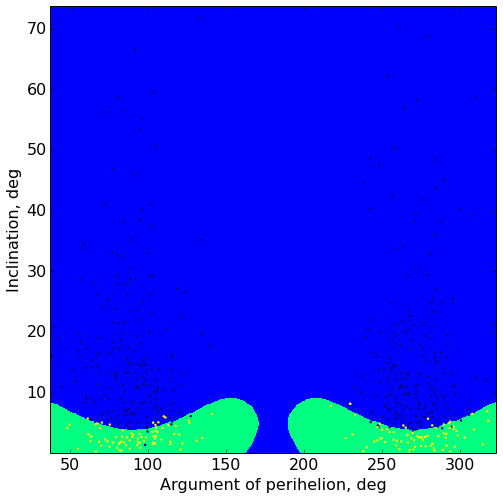

In [20]:
vd.plot_clf2d(clf_aa, cutcol, haz_cut=haz_gen_cut, nohaz_cut=nohaz_gen_cut, s=6,
              num=500, scales=atiras_atens_wi_sc, labels=True, cmap='winter', figsize=(8, 8) )

In [21]:
haz_gen_extracted_aa.append(haz_gen_atiras_atens_wi)
nohaz_gen_trapped_aa.append(nohaz_gen_atiras_atens_wi)

haz_real_extracted_aa.append(haz_real_atiras_atens_wi)
nohaz_real_trapped_aa.append(nohaz_real_atiras_atens_wi)

### Atiras & Atens divisions qualitiy

** Divisions quality for virtual Atiras & Atens **

In [22]:
vd.print_summary(haz_gen_extracted_aa, nohaz_gen_trapped_aa, 
                 haz_gen_atiras_atens, nohaz_gen_atiras_atens, 'virtual')

Number of correctly classified virtual PHAs 129
Number of trapped virtual NHAs: 14

Mass fraction of correctly classified virtual PHAs: 0.871621621622
Mass fraction of trapped virtual NHAs: 0.033734939759

Cummulative purity of the outlined PHA regions: 0.902097902098


** Divisions quality for real Atiras & Atens **

In [23]:
vd.print_summary(haz_real_extracted_aa, nohaz_real_trapped_aa, 
                 haz_real_atiras_atens, nohaz_real_atiras_atens, 'real')

Number of correctly classified real PHAs 1
Number of trapped real NHAs: 0

Mass fraction of correctly classified real PHAs: 1.0
Mass fraction of trapped real NHAs: 0.0

Cummulative purity of the outlined PHA regions: 1.0


---
## Apollos

In [24]:
haz_gen_extracted_ap = []
nohaz_gen_trapped_ap = []

haz_real_extracted_ap = []
nohaz_real_trapped_ap = []

In [25]:
haz_gen_apollo, haz_gen_apollo_num = rdb.get_apollos(haz_gen)
nohaz_gen_apollo, nohaz_gen_apollo_num = rdb.get_apollos(nohaz_gen)
apollo_gen_num = haz_gen_apollo_num + nohaz_gen_apollo_num

haz_real_apollo, haz_real_apollo_num = rdb.get_apollos(haz_real)
nohaz_real_apollo, nohaz_real_apollo_num = rdb.get_apollos(nohaz_real)
apollo_real_num = haz_real_apollo_num + nohaz_real_apollo_num

** Virtual Apollos **

In [26]:
print "Number of virtual PHAs in the group:", haz_gen_apollo_num
print "Number of virtual NHAs in the group:", nohaz_gen_apollo_num
print "Number of virtual Apollo:", apollo_gen_num
print "Apollo group weight:", float(apollo_gen_num)/gen_num

Number of virtual PHAs in the group: 2177
Number of virtual NHAs in the group: 2470
Number of virtual Apollo: 4647
Apollo group weight: 0.891938579655


** Real Apollos **

In [27]:
print "Number of real PHAs in the group:", haz_real_apollo_num
print "Number of real NHAs in the group:", nohaz_real_apollo_num
print "Number of real Apollo:", apollo_real_num
print "Apollo group weight:", float(apollo_real_num)/real_num

Number of real PHAs in the group: 37
Number of real NHAs in the group: 30
Number of real Apollo: 67
Apollo group weight: 0.779069767442


In [28]:
# vd.display_allparams([haz_gen_apollo, nohaz_gen_apollo], vd.combs, vd.colnames)

### Split Apolllos by a *w*-*q*-*i* suarface

** Amplify Apollos by their symmetric copies over the *w* parameter **

In [29]:
haz_gen_apollo_se = ld.add_doublemirror_column(haz_gen_apollo, 'w', 180.0)
nohaz_gen_apollo_se = ld.add_doublemirror_column(nohaz_gen_apollo, 'w', 180.0)

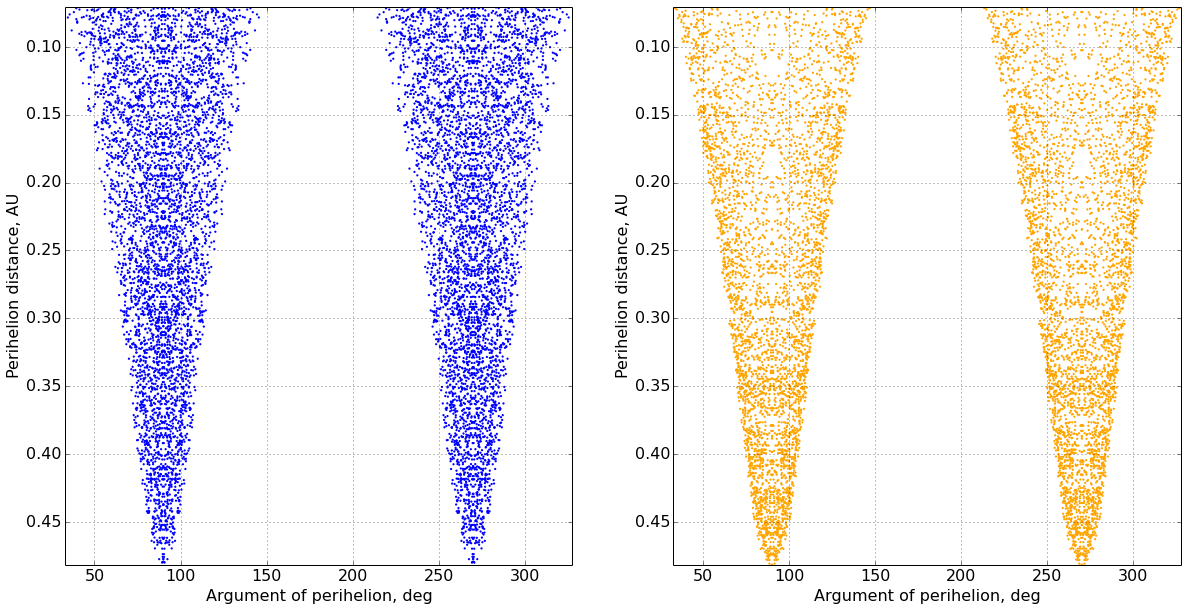

In [30]:
cutcol = ['w', 'q']
vd.plot_distributions2d(cutcol, haz_gen_apollo_se, nohaz_gen_apollo_se, labels=True, invertaxes=[0,1])

** Cut *w*, *q* and *i* columns and nomalize datasets **

In [31]:
cutcol = ['w', 'q', 'i']
pairs, apollo_wqi_sc = ld.cut_normalize(cutcol, [haz_gen_apollo, nohaz_gen_apollo], 
                                                [haz_real_apollo, nohaz_real_apollo],
                                                [haz_gen_apollo_se, nohaz_gen_apollo_se])
haz_gen_cut, nohaz_gen_cut = pairs[0]
haz_real_cut, nohaz_real_cut = pairs[1]
haz_gen_se_cut, nohaz_gen_se_cut = pairs[2]

** Prepare *w*-*q* domain mask to exclude out-of-domain points from the plot **

In [32]:
# genu = pd.concat((haz_genu, nohaz_genu, haz_gen, nohaz_gen))
# genu_rest = pd.concat((haz_genu_rest, nohaz_genu_rest, haz_gen_rest, nohaz_gen_rest))
genu = pd.concat((haz_genu, nohaz_genu))
genu_rest = pd.concat((haz_genu_rest, nohaz_genu_rest))

genu_se = ld.add_doublemirror_column(genu, 'w', 180.0)
genu_rest_se = ld.add_doublemirror_column(genu_rest, 'w', 180.0)

apollo_wq_sc = apollo_wqi_sc[:2]

In [33]:
cutcol_ = ['w', 'q']
clfmask = svm.SVC(gamma=10.0, C=500.0, class_weight={1: 10})
clfmask = al.sgmask_clf2d_fit(clfmask, cutcol_, genu_se, genu_rest_se, apollo_wq_sc)

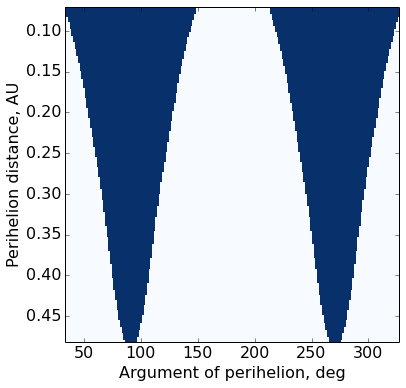

In [34]:
vd.plot_clf2d(clfmask, cutcol_, num=200, figsize=(6,6), scales=apollo_wq_sc, 
                   labels=True, cmap='Blues', invertaxes=[0, 1])

** Train SVM **

In [35]:
clf_apollo = svm.SVC(gamma=20.0, C=0.5)
xtrain, ytrain = ld.mix_up(haz_gen_se_cut, nohaz_gen_se_cut)
clf_apollo = clf_apollo.fit(xtrain, ytrain)

In [36]:
# cutcol = ['w', 'q', 'i']
# clf_apollo_wqi = svm.SVC(gamma=20.0, C=0.5)
# splitres = al.split_by_clf(clf_apollo_wqi, cutcol,   haz_gen_apollo_se,
#                                                      nohaz_gen_apollo_se,
#                                                      haz_gen_apollo,
#                                                      nohaz_gen_apollo)

# haz_gen_apollo_wqi, nohaz_gen_apollo_wqi = splitres[0]
# haz_gen_apollo_wqi__, nohaz_gen_apollo_wqi__ = splitres[1]
# haz_gen_apollo_wqi_sc = splitres[2]

** Estimate split quality for virtual Apollos **

In [37]:
predicted_gen = al.clf_split_quality(clf_apollo, haz_gen_cut, nohaz_gen_cut)

haz_gen_apollo_wqi = haz_gen_apollo.iloc[predicted_gen[0]]
nohaz_gen_apollo_wqi = nohaz_gen_apollo.iloc[predicted_gen[1]]

haz_gen_apollo_wqi__ = haz_gen_apollo.iloc[predicted_gen[2]]
nohaz_gen_apollo_wqi__ = nohaz_gen_apollo.iloc[predicted_gen[3]]

purity of PHA region: 0.939252336449
number of PHAs in the PHA region: 2010
number of NHAs in the PHA region: 130

purity of NHA region: 0.93338651775
number of PHAs in the NHA region: 167
number of NHAs in the NHA region: 2340

fraction of correctly classified PHAs: 0.92328892972


** Estimate split quality for real Apollos **

In [38]:
predicted_real = al.clf_split_quality(clf_apollo, haz_real_cut, nohaz_real_cut)

haz_real_apollo_wqi = haz_real_apollo.iloc[predicted_real[0]]
nohaz_real_apollo_wqi = nohaz_real_apollo.iloc[predicted_real[1]]

haz_real_apollo_wqi__ = haz_real_apollo.iloc[predicted_real[2]]
nohaz_real_apollo_wqi__ = nohaz_real_apollo.iloc[predicted_real[3]]

purity of PHA region: 0.971428571429
number of PHAs in the PHA region: 34
number of NHAs in the PHA region: 1

purity of NHA region: 0.90625
number of PHAs in the NHA region: 3
number of NHAs in the NHA region: 29

fraction of correctly classified PHAs: 0.918918918919


In [39]:
print "Mass fraction of correctly classified PHAs:", float(len(haz_gen_apollo_wqi))/haz_gen_apollo_num
print "Mass fraction of trapped NHAs:", float(len(nohaz_gen_apollo_wqi))/nohaz_gen_apollo_num

Mass fraction of correctly classified PHAs: 0.92328892972
Mass fraction of trapped NHAs: 0.0526315789474


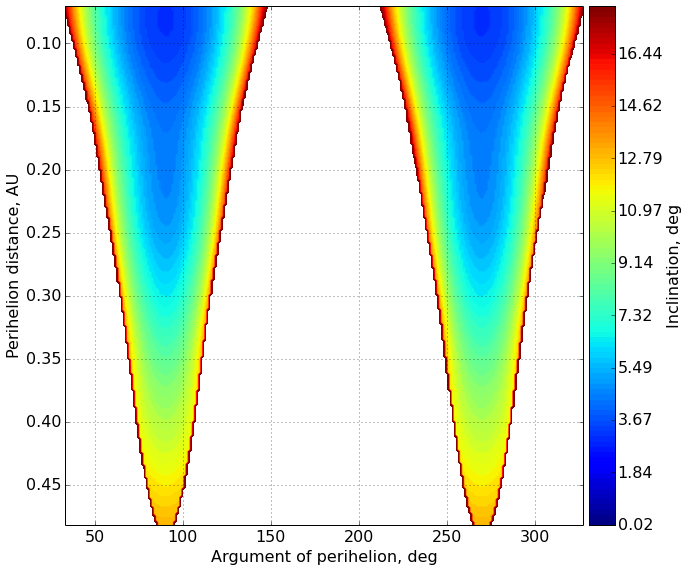

In [40]:
# cutcol = ['w', 'q', 'i']
# clf_masks = [(clfmask, 0)]
# labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo, cutcol, num=250, labels=True, figsize=(9,8), mode='2d', 
              scales=apollo_wqi_sc, clf_masks=[(clfmask, 0)], invertaxes=[0, 1]) 

In [41]:
haz_gen_extracted_ap.append(haz_gen_apollo_wqi)
nohaz_gen_trapped_ap.append(nohaz_gen_apollo_wqi)

haz_real_extracted_ap.append(haz_real_apollo_wqi)
nohaz_real_trapped_ap.append(nohaz_real_apollo_wqi)

### Apollo divisions qualitiy

** Divisions quality for virtual Apollos **

In [42]:
vd.print_summary(haz_gen_extracted_ap, nohaz_gen_trapped_ap, haz_gen_apollo, nohaz_gen_apollo, 'virtual')

Number of correctly classified virtual PHAs 2010
Number of trapped virtual NHAs: 130

Mass fraction of correctly classified virtual PHAs: 0.92328892972
Mass fraction of trapped virtual NHAs: 0.0526315789474

Cummulative purity of the outlined PHA regions: 0.939252336449


** Divisions quality for real Apollos **

In [43]:
vd.print_summary(haz_real_extracted_ap, nohaz_real_trapped_ap, haz_real_apollo, nohaz_real_apollo, 'real')

Number of correctly classified real PHAs 34
Number of trapped real NHAs: 1

Mass fraction of correctly classified real PHAs: 0.918918918919
Mass fraction of trapped real NHAs: 0.0333333333333

Cummulative purity of the outlined PHA regions: 0.971428571429


## Count down cummulative split quality

** Virtual asteroids **

In [44]:
haz_gen_extracted = haz_gen_extracted_aa + haz_gen_extracted_ap
nohaz_gen_trapped = nohaz_gen_trapped_aa + nohaz_gen_trapped_ap

In [45]:
vd.print_summary(haz_gen_extracted, nohaz_gen_trapped, haz_gen, nohaz_gen, 'virtual')

Number of correctly classified virtual PHAs 2139
Number of trapped virtual NHAs: 144

Mass fraction of correctly classified virtual PHAs: 0.92
Mass fraction of trapped virtual NHAs: 0.0499133448873

Cummulative purity of the outlined PHA regions: 0.936925098555


**Real asteroids **

In [46]:
haz_real_extracted = haz_real_extracted_aa + haz_real_extracted_ap
nohaz_real_trapped = nohaz_real_trapped_aa + nohaz_real_trapped_ap

In [47]:
vd.print_summary(haz_real_extracted, nohaz_real_trapped, haz_real, nohaz_real, 'real')

Number of correctly classified real PHAs 35
Number of trapped real NHAs: 1

Mass fraction of correctly classified real PHAs: 0.921052631579
Mass fraction of trapped real NHAs: 0.0208333333333

Cummulative purity of the outlined PHA regions: 0.972222222222
